# Introduction to Sionna RT

Ray tracing is a technique to simulate environment-specific and physically accurate channel realizations for a given scene and user position.
Please see the [EM Primer](https://nvlabs.github.io/sionna/rt/em_primer.html) for further details on the theoretical background of ray tracing of wireless channels.

Sionna RT is a open-source hardware-accelerated differentiable ray tracer for radio propagation modeling which is built on top of [Mitsuba 3](https://www.mitsuba-renderer.org/). Mitsuba 3 is a rendering system for forward and inverse light-transport simulation that makes use of the differentiable just-in-time compiler [Dr.Jit](https://drjit.readthedocs.io/en/latest/).

Thanks to Dr.Jit's automatic gradient computation, gradients of functions of channel responses or radio maps with respect to most parameters of the ray tracing process, including material properties, antenna and scattering patterns, orientations, and positions of objects, can be efficiently computed and used in various gradient-based optimization problems.

Sionna RT relies on Mitsuba 3 for the rendering and handling of scenes, e.g., its XML-file format.

Scene files for Mitsuba 3 can be created, edited, and exported with the popular open-source 3D creation suite [Blender](https://www.blender.org/) and the [Mitsuba-Blender add-on](https://github.com/mitsuba-renderer/mitsuba-blender). One can rapdily create scenes from almost any place in the world using [OpenStreetMap](https://www.openstreetmap.org/) and the [Blender-OSM add-on](https://prochitecture.gumroad.com/l/blender-osm). In Sionna, scenes and radio propagation paths can be either rendered through the lens of configurable cameras via ray tracing or displayed with an integrated 3D viewer. For more detail on scene creation and rendering, we refer to [Sionna RT's API documentation](https://nvlabs.github.io/sionna/rt/api/rt.html) and the available [video tutorial](https://youtu.be/7xHLDxUaQ7c).

## Imports

In [1]:
# Import or install Sionna
try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt

# Other imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

no_preview = True # Toggle to False to use the preview widget

# Import relevant components from Sionna RT
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera,\
                      PathSolver, RadioMapSolver, subcarrier_frequencies

## Loading and Visualizing Scenes

Sionna RT can either load external scene files (in Mitsuba's XML file format) or it can load one of the [integrated scenes](https://nvlabs.github.io/sionna/rt/api/scene.html#examples).

In this example, we load an example scene containing the area around the Frauenkirche in Munich, Germany.

In [2]:
# Load integrated scene
scene = load_scene(sionna.rt.scene.munich) # Try also sionna.rt.scene.etoile

To visualize the scene, we can use the `preview` function which opens an interactive preview of the scene.
This only works in Jupyter notebooks.

You can use the following controls:

- Mouse left: Rotate
- Scroll wheel: Zoom
- Mouse right: Move

Please note that only one preview instance per scene can be opened at the same time.
However, multiple scenes can be loaded in parallel.

In [3]:
if not no_preview:
    scene.preview();

It is often convenient to choose a viewpoint in the 3D preview prior to rendering it as a high-quality image.
The next cell uses the "preview" camera which corresponds to the viewpoint of the current preview image.

In [4]:
# Only availabe if a preview is open
if not no_preview:
    scene.render(camera="preview", num_samples=512);

One can also render the image to a file as shown below:

In [5]:
# Only availabe if a preview is open
if not no_preview:
    scene.render_to_file(camera="preview",
                         filename="scene.png",
                         resolution=[650,500]);

Instead of the preview camera, one can also specify dedicated cameras with different positions and `look_at` directions.

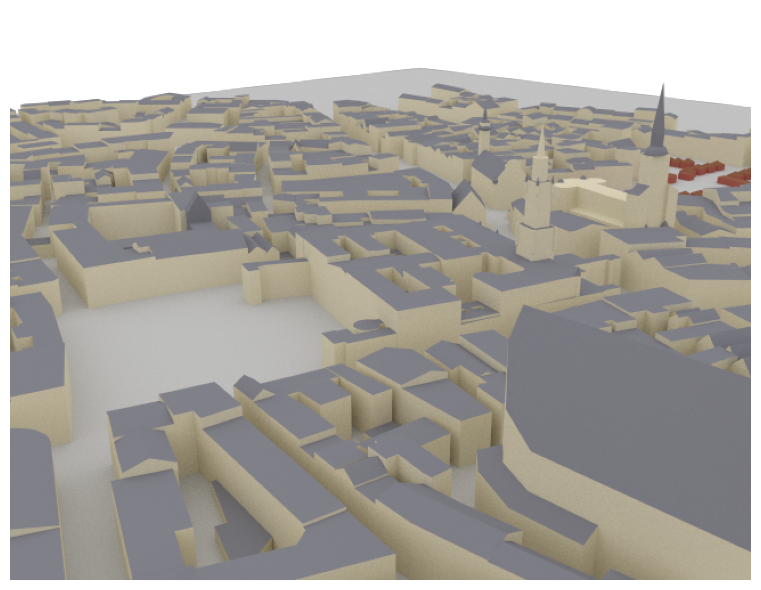

In [6]:
# Create new camera with different configuration
my_cam = Camera(position=[-250,250,150], look_at=[-15,30,28])

# Render scene with new camera*
scene.render(camera=my_cam, resolution=[650, 500], num_samples=512); # Increase num_samples to increase image quality

## Inspecting SceneObjects and Editing of Scenes

A scene consists of multiple [SceneObjects](https://nvlabs.github.io/sionna/rt/api/scene_object.html) which can be accessed in the following way:

In [7]:
scene = load_scene(sionna.rt.scene.simple_street_canyon, merge_shapes=False)
scene.objects

{'building_1': <sionna.rt.scene_object.SceneObject at 0x7f0fbadbcce0>,
 'building_6': <sionna.rt.scene_object.SceneObject at 0x7f0fbadbd400>,
 'building_5': <sionna.rt.scene_object.SceneObject at 0x7f0fbadbc9e0>,
 'building_4': <sionna.rt.scene_object.SceneObject at 0x7f0fbadbdc40>,
 'building_3': <sionna.rt.scene_object.SceneObject at 0x7f0fbadbdbe0>,
 'building_2': <sionna.rt.scene_object.SceneObject at 0x7f0fbadbddf0>,
 'floor': <sionna.rt.scene_object.SceneObject at 0x7f0fbadbde80>}

In [8]:
floor = scene.get("floor")

SceneObjects can be transformed by the following properties and methods: 
- position
- orientation
- scaling
- look_at

In [9]:
print("Position (x,y,z) [m]: ", floor.position)
print("Orientation (alpha, beta, gamma) [rad]: ", floor.orientation)
print("Scaling: ", floor.scaling)

Position (x,y,z) [m]:  [[-0.769669, 0.238537, -0.0307941]]
Orientation (alpha, beta, gamma) [rad]:  [[0, 0, 0]]
Scaling:  [1]


More details on these functionalities can be found in the [Tutorial on Loading and Editing of Scenes](https://nvlabs.github.io/sionna/rt/tutorials/Scene-Edit.html).

Every SceneObject has another important property, the `velocity` vector:

In [10]:
print("Velocity (x,y,z) [m/s]: ", floor.velocity)

Velocity (x,y,z) [m/s]:  [[0, 0, 0]]


This property is used during the ray tracing process to compute a Doppler shift for every propagation path. This information can then be used to synthetically compute time evolution of channel impulse responses. More details on this topic are provided in the [Tutorial on Mobility](https://nvlabs.github.io/sionna/rt/tutorials/Mobility.html).

The last property of SceneObjects that we discuss here is the [RadioMaterial](https://nvlabs.github.io/sionna/rt/api/radio_materials.html):

In [11]:
floor.radio_material

ITURadioMaterial type=concrete
                 eta_r=5.240
                 sigma=0.123
                 thickness=0.100
                 scattering_coefficient=0.000
                 xpd_coefficient=0.000

The radio material determines how an object interacts with incident radio waves. To learn more about radio materials and how they can be modified, we invited you to have a look at the Developer Guide on [Understanding Radio Materials](https://nvlabs.github.io/sionna/rt/developer/dev_custom_radio_materials.html).

Depending on the type of radio material, some of its properties might change as a function of the frequency of the incident radio wave:

In [12]:
scene.frequency = 28e9 # in Hz; implicitly updates RadioMaterials that implement frequency dependent properties
floor.radio_material # Note that the conductivity (sigma) changes automatically

ITURadioMaterial type=concrete
                 eta_r=5.240
                 sigma=0.626
                 thickness=0.100
                 scattering_coefficient=0.000
                 xpd_coefficient=0.000

## Ray tracing of Propagation Paths

One a scene is loaded, we can place Transmitters and Receivers in it and compute propagation paths between them.
All transmitters and all receivers are equipped with the same antenna arrays which are defined by the `scene` properties `scene.tx_array` and `scene.rx_array`, respectively. Antenna arrays are composed of multiple identical antennas. Antennas can have custom or pre-defined patterns and are either single- or dual-polarized. One can add multiple transmitters and receivers to a scene which need to have unique names.

More details on antenna patterns can be found in the Developer Guide [Understanding Radio Materials](https://nvlabs.github.io/sionna/rt/developer/dev_custom_radio_materials.html).

In [13]:
scene = load_scene(sionna.rt.scene.munich, merge_shapes=True) # Merge shapes to speed-up computations

# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="cross")

# Create transmitter
tx = Transmitter(name="tx",
                 position=[8.5,21,27],
                 display_radius=2)

# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name="rx",
              position=[45,90,1.5],
              display_radius=2)

# Add receiver instance to scene
scene.add(rx)

tx.look_at(rx) # Transmitter points towards receiver

Propagation paths are computed with the help of a [PathSolver](https://nvlabs.github.io/sionna/rt/api/paths_solvers.html).
The next cell shows how such a path solver is instantiated and used. 

The parameter `max_depth` determines the maximum number of interactions between a ray and a scene objects. 
For example, with a `max_depth` of zero, only LoS paths are considered For a `max_depth` of one, LoS as well as first-order reflections of refractions are considered.  When the argument `synthetic_array` is set to `False`, antenna arrays are explicitly modeled by finding paths between any pair of transmitting and receiving antennas in the scene. Otherwise, arrays are represented by a single antenna located in the center of the array.
Phase shifts related to the relative antenna positions will then be applied based on a plane-wave assumption when the channel impulse responses are computed.

In [14]:
# Instantiate a path solver
# The same path solver can be used with multiple scenes
p_solver  = PathSolver()

# Compute propagation paths
paths = p_solver(scene=scene,
                 max_depth=5,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=False,
                 refraction=True,
                 synthetic_array=False,
                 seed=41)

The [Paths](https://nvlabs.github.io/sionna/rt/paths.html) object contains all paths that have been found between transmitters and receivers.
In principle, the existence of each path is determininistic for a given position and environment. Please note that due to the stochastic nature of the *shoot-and-bounce* algorithm, different runs of the path solver can lead to different paths that are found. Most importantly, diffusely reflected paths are obtained through random sampling of directions after each interaction with a scene object. You can provide the `seed` argument to the solver to ensure reproducibility.

Let us now visualize the found paths in the scene:

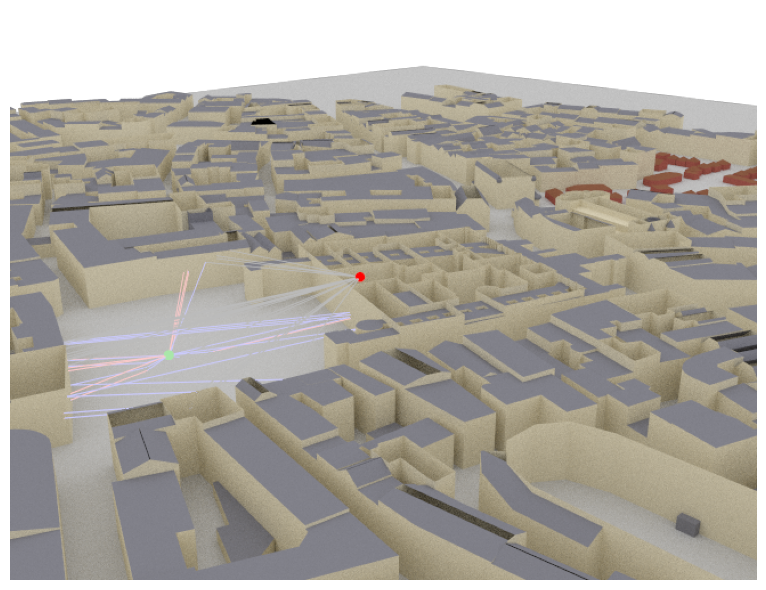

In [15]:
if no_preview:
    scene.render(camera=my_cam, paths=paths, clip_at=20);
else:
    scene.preview(paths=paths, clip_at=20);

The Paths object contains detailed information about every found path and allows us to generated channel impulse responses and apply Doppler shifts for the simulation of time evolution. For a detailed description, we refer to the developer guide [Understanding the Paths Object](https://nvlabs.github.io/sionna/rt/developer/dev_understanding_paths.html).

## From Paths to Channel Impulse and Frequency Responses

Once paths are computed, they can be transformed into a baseband-equivalent channel impulse response (CIR) via [Paths.cir()](https://nvlabs.github.io/sionna/rt/api/paths.html#sionna.rt.Paths.cir), into a discrete complex baseband-equivalent channel impulse response via [Paths.taps()](https://nvlabs.github.io/sionna/rt/api/paths.html#sionna.rt.Paths.taps), or into a channel frequency response (CFR) via
[Paths.cfr()](https://nvlabs.github.io/sionna/rt/api/paths.html#sionna.rt.Paths.cfr). These class methods can simulate time evolution of the channel based on the computed Doppler shifts (see [Paths.doppler](https://nvlabs.github.io/sionna/rt/api/paths.html#sionna.rt.Paths.doppler)).

Let us first derive and visualize the baseband-equivalent channel impulse response from the paths computed above:

In [16]:
a, tau = paths.cir(normalize_delays=True, out_type="numpy")

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
print("Shape of a: ", a.shape)

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths]
print("Shape of tau: ", tau.shape)

Shape of a:  (1, 2, 1, 1, 20, 1)
Shape of tau:  (1, 2, 1, 1, 20)


The `out_type` argument can be used to convert the CIR into tensors from different frameworks, such as [Dr.Jit](https://drjit.readthedocs.io/en/latest/reference.html) ("drjit"), [Numpy](https://numpy.org) ("numpy"),
            [Jax](https://jax.readthedocs.io/en/latest/index.html) ("jax"),
            [TensorFlow](https://www.tensorflow.org) ("tf"),
            and [PyTorch](https://pytorch.org) ("torch"). Please see the developer guide [Compatibility with other Frameworks](https://nvlabs.github.io/sionna/rt/developer/dev_compat_frameworks.html) for more information on the interoperability of Sionna RT with other array frameworks, including the propagation of gradients.

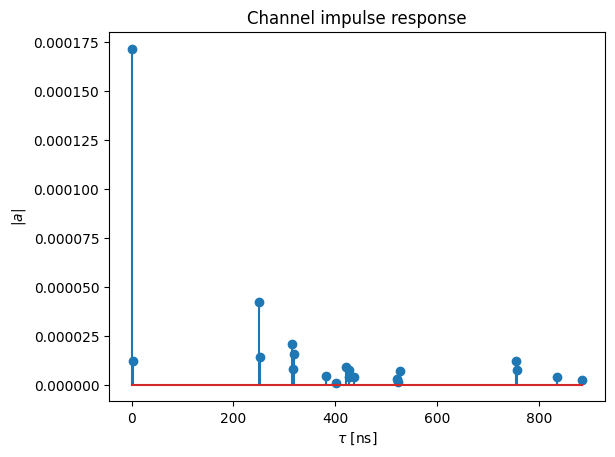

In [17]:
t = tau[0,0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,:,0]
a_max = np.max(a_abs)

# And plot the CIR
plt.figure()
plt.title("Channel impulse response")
plt.stem(t, a_abs)
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");

Note that the delay of the first arriving path is by default normalized to zero. This behavior can be changed by setting the argument ``normalize_delays`` to `True`.

We can obtain the channel frequency response in a similar manner:

Shape of h_freq:  (1, 2, 1, 1, 1, 1024)


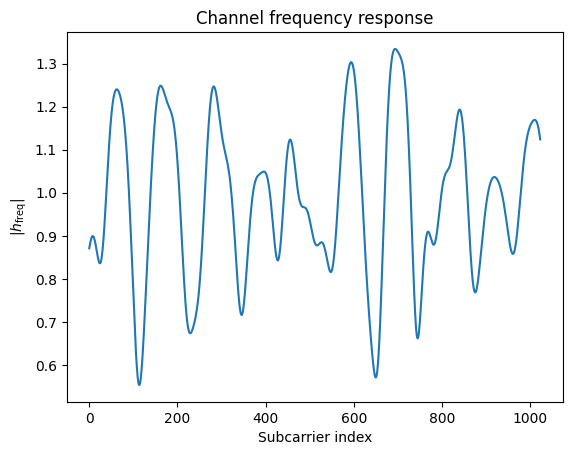

In [18]:
# OFDM system parameters
num_subcarriers = 1024
subcarrier_spacing=30e3

# Compute frequencies of subcarriers relative to the carrier frequency
frequencies = subcarrier_frequencies(num_subcarriers, subcarrier_spacing)

# Compute channel frequency response
h_freq = paths.cfr(frequencies=frequencies,
                   normalize=True, # Normalize energy
                   normalize_delays=True,
                   out_type="numpy")

# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, num_subcarriers]
print("Shape of h_freq: ", h_freq.shape)

# Plot absolute value
plt.figure()
plt.plot(np.abs(h_freq)[0,0,0,0,0,:]);
plt.xlabel("Subcarrier index");
plt.ylabel(r"|$h_\text{freq}$|");
plt.title("Channel frequency response");

For link-level simulations in the time-domain, we often require the discrete baseband-equivalent channel impulse response or simply the channel taps.
These are obtained by sampling the ideally low-pass filtered channel impulse response at the desired sampling frequency. By default, it is assumed that sampling is performed at the Nyquist rate.

As the underlying sinc filter has an infinitely long response, the channel taps need to be truncated at a minimum and maximum value, i.e., `l_min` and `l_max`, respectively.

Shape of taps:  (1, 2, 1, 1, 1, 107)


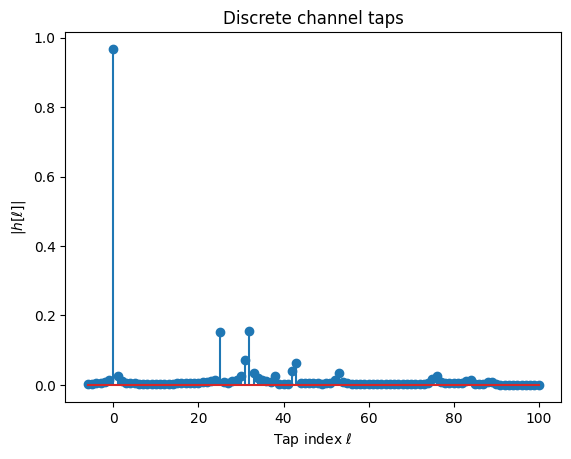

In [19]:
taps = paths.taps(bandwidth=100e6, # Bandwidth to which the channel is low-pass filtered
                  l_min=-6,        # Smallest time lag
                  l_max=100,       # Largest time lag
                  sampling_frequency=None, # Sampling at Nyquist rate, i.e., 1/bandwidth
                  normalize=True,  # Normalize energy
                  normalize_delays=True,
                  out_type="numpy")
print("Shape of taps: ", taps.shape)

plt.figure()
plt.stem(np.arange(-6, 101), np.abs(taps)[0,0,0,0,0]);
plt.xlabel(r"Tap index $\ell$");
plt.ylabel(r"|$h[\ell]|$");
plt.title("Discrete channel taps");

Every radio device and scene object has a velocity vector associated with it. These are used to compute path-specific Doppler shifts that enable the simulation of mobility. More details can be found in the [Tutorial on Mobility](https://nvlabs.github.io/sionna/rt/tutorials/Mobility.html).

We will now assign a non-zero velocity vector to the transmitter, recompute the propagation paths, and compute a time-varying channel impulse reponse:

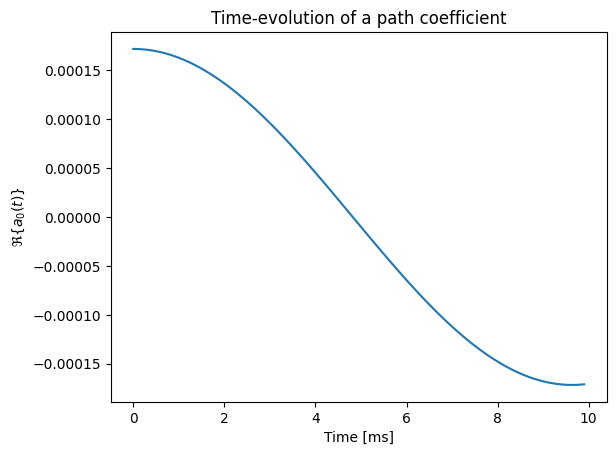

In [20]:
scene.get("tx").velocity = [10, 0, 0]

# Recompute propagation paths
paths_mob = p_solver(scene=scene,
                     max_depth=5,
                     los=True,
                     specular_reflection=True,
                     diffuse_reflection=False,
                     refraction=True,
                     synthetic_array=True,
                     seed=41)

# Compute CIR with time-evolution
num_time_steps=100
sampling_frequency = 1e4
a_mob, _ = paths_mob.cir(sampling_frequency=sampling_frequency,
                         num_time_steps=num_time_steps,
                         out_type="numpy")

# Inspect time-evolution of a single path coefficient
plt.figure()
plt.plot(np.arange(num_time_steps)/sampling_frequency*1000,
         a_mob[0,0,0,0,0].real);
plt.xlabel("Time [ms]");
plt.ylabel(r"$\Re\{a_0(t) \}$");
plt.title("Time-evolution of a path coefficient");

## Radio Maps

Sionna RT can compute radio maps for all transmitters in a scene. A [RadioMap](https://nvlabs.github.io/sionna/rt/api/radio_map.html) assigns a metric, such as path gain, received signal strength (RSS), or signal-to-interference-plus-noise ratio (SINR), for a specific transmitter to every point on a plane. In other words, for a given transmitter, it associates every point on a surface with the channel gain, RSS, or SINR, that a receiver with a specific orientation would observe at this point.

Like the computation of propagation paths requires a [PathSolver](https://nvlabs.github.io/sionna/rt/api/paths_solvers.html), the computation of radio maps requires a [RadioMapSolver](https://nvlabs.github.io/sionna/rt/api/radio_map_solvers.html). The following code snippet how a radio can be computed and displayed.

More information about radio maps can be found in the detailed [Tutorial on Radio Maps](https://nvlabs.github.io/sionna/rt/tutorials/Radio-Maps.html).

In [21]:
rm_solver = RadioMapSolver()

rm = rm_solver(scene=scene, 
               max_depth=5,
               cell_size=[1,1],
               samples_per_tx=10**6)

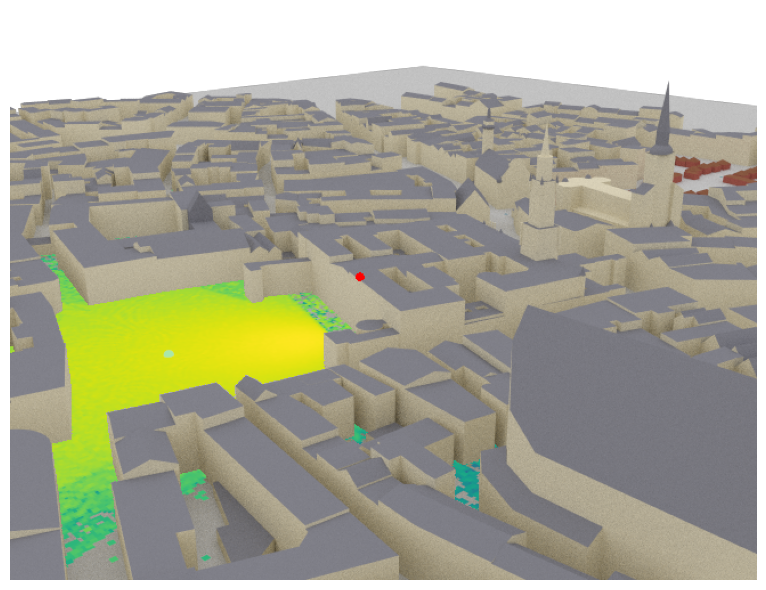

In [22]:
if no_preview:
    scene.render(camera=my_cam, radio_map=rm);
else:
    scene.preview(radio_map=rm);

## Summary

In this tutorial, you have learned the basics of Sionna RT. You now know how paths can be found in complex environments
and how the CIR, CFR, and taps can be derived from them. You have also learned how radio maps can be created.

There is one key feature of Sionna RT that was not discussed in this notebook: Automatic gradient computation.
Like most components of Sionna, also Sionna RT is differentiable with respect to most parameters, such as radio materials, scattering and atenna patterns, transmitter and receiver orientations, array geometries, positions, etc.

Please have a look at the [API documentation](https://nvlabs.github.io/sionna/rt/api/rt.html) of the various components and the other available [Tutorials](https://nvlabs.github.io/sionna/rt/tutorials.html) and [Developer Guides](https://nvlabs.github.io/sionna/rt/developer/developer.html).